In [1]:
import tensorflow as tf
import numpy as np

In [2]:
indices = tf.constant([[[0, 1], [0, 0], [0, 2], [0, 3]], 
                      [[1, 0], [1, 1], [1, 2], [1, 3]]])
updates = tf.constant([[5, 6, 7, 8],
                        [1, 2, 3, 4]])
shape = tf.constant([2, 4])
scatter1 = tf.scatter_nd(indices, updates, shape)
with tf.Session() as sess:
    print(sess.run(scatter1))

[[6 5 7 8]
 [1 2 3 4]]


In [3]:
t = np.array([[0], [2]], dtype=np.int32)
indices = tf.constant(t)
print (t.shape)

t = np.array([[[5, 5, 5, 5], [6, 6, 6, 6],
                        [7, 7, 7, 7], [8, 8, 8, 8]],
                       [[5, 5, 5, 5], [6, 6, 6, 6],
                        [7, 7, 7, 7], [8, 8, 8, 8]]])
updates = tf.constant(t)
print (t.shape)

shape = tf.constant([4, 4, 4])
scatter = tf.scatter_nd(indices, updates, shape)
with tf.Session() as sess:
    a = sess.run(scatter)
    print (a.shape)

(2, 1)
(2, 4, 4)
(4, 4, 4)


In [4]:
indices.shape

TensorShape([Dimension(2), Dimension(1)])

In [5]:
import cv2
import os

In [6]:
import matplotlib
from matplotlib import pyplot as pl
%matplotlib inline

def crop_and_resize (frame):
    return cv2.resize(frame[36:250, 114:328, :], (15, 15), interpolation = cv2.INTER_LINEAR)


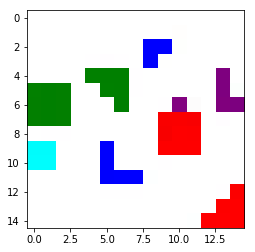

In [31]:
cap = cv2.VideoCapture(os.path.join('..', 'target', '0', '1.mp4'))
ret, frame = cap.read()

img = crop_and_resize(frame)

pl.imshow(img)

In [8]:
img.shape

(15, 15, 3)

In [9]:
def create_indices ( shape, pos, action ):
    # Because we will only shift cell in the first 2 dimensions
    indices = np.zeros((shape, shape, 2), dtype=np.int32)
    
    for i in range(shape):
        for j in range(shape):
            indices[i,j]= [i,j]
            
    # If the move is not executable
    # just return indices
    
    i = pos[0]
    j = pos[1]
    
    if action == 'left':
        indices[i,j] = [i,j-1]
        indices[i,j-1] = [i,j]
        
    if action == 'right':
        indices[i,j] = [i,j+1]
        indices[i,j+1] = [i,j]
        
    if action == 'up':
        indices[i,j] = [i-1,j]
        indices[i-1,j] = [i,j]
        
    if action == 'down':
        indices[i,j] = [i+1,j]
        indices[i+1,j] = [i,j]
        
    return tf.constant(indices)

from tensorflow.python.framework import ops

/Users/tuando/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


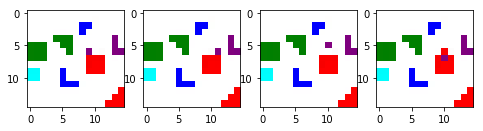

In [17]:
updates = tf.constant(img)
shape = tf.constant([15, 15, 3])

fig=pl.figure(figsize=(8, 8))

action_tensors = []
map_indices = {}
for action in ['left', 'right', 'up', 'down']:
    action_tensors.append(ops.convert_to_tensor( action ))

pos = [6,10]
s = 15

def scatter_function(size, pos, action, updates, shape):
    indices = create_indices(size, pos, action)
    
    return tf.scatter_nd(indices, updates, shape)

with tf.Session() as sess:
#     new_img = sess.run(scatter_function(s, pos, 'left', updates, shape))
#     indices = create_indices(s, pos, 'left')
    
#     scatter1 = tf.scatter_nd(indices, updates, shape)
    
#     new_img = sess.run(scatter1)
    
    fig.add_subplot(1, 4, 1)
    pl.imshow(new_img)
        
    for i, action in enumerate(action_tensors):
        scatter = tf.case(
            {tf.equal(action, tf.constant('left')): lambda : scatter_function(s, pos, 'left', updates, shape), 
             tf.equal(action, tf.constant('right')): lambda : scatter_function(s, pos, 'right', updates, shape),
             tf.equal(action, tf.constant('up')): lambda : scatter_function(s, pos, 'up', updates, shape),
             tf.equal(action, tf.constant('down')): lambda : scatter_function(s, pos, 'down', updates, shape)},
             default=lambda : scatter_function(s, pos, 'stop', updates, shape),exclusive=True)
            
        new_img = sess.run(scatter)
    
        fig.add_subplot(1, 4, i + 1)
        pl.imshow(new_img)
        
pl.show()

In [37]:
def whitening(img):
    """
    Turn value of img that close to 255 to exact 255
    """
    img[img >  245] = 255

In [38]:
whitening(img)

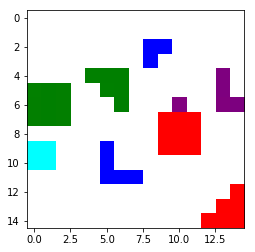

In [39]:
pl.imshow(img)

In [42]:
def scatter_function_condition(size, pos, action, updates, shape):
    i = pos[0]
    j = pos[1]
    
    if action == 'left':
        j -= 1
        
    if action == 'right':
        j += 1
        
    if action == 'up':
        i -= 1
        
    if action == 'down':
        i += 1
    
    t = tf.reduce_sum(tf.gather_nd(updates, [i,j]))
    
    # white color has t == 255 * 3
    return tf.case(
            {tf.equal(t, tf.constant(255 * 3)): lambda : updates,
             tf.equal(ops.convert_to_tensor(i), tf.constant(-1)): lambda : updates,
             tf.equal(ops.convert_to_tensor(j), tf.constant(-1)): lambda : updates,
             tf.equal(ops.convert_to_tensor(i), tf.constant(size)): lambda : updates,
             tf.equal(ops.convert_to_tensor(j), tf.constant(size)): lambda : updates,
            },
        default = tf.scatter_nd(create_indices(size, pos, action), updates, shape))

/Users/tuando/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


TypeError: Input 'y' of 'Equal' Op has type int32 that does not match type uint8 of argument 'x'.

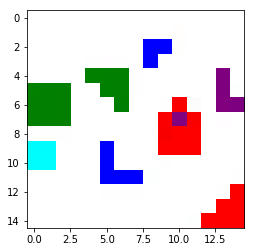

In [43]:
with tf.Session() as sess:
#     new_img = sess.run(scatter_function(s, pos, 'left', updates, shape))
#     indices = create_indices(s, pos, 'left')
    
#     scatter1 = tf.scatter_nd(indices, updates, shape)
    
#     new_img = sess.run(scatter1)
    
    fig.add_subplot(1, 4, 1)
    pl.imshow(new_img)
        
    for i, action in enumerate(action_tensors):
        scatter = tf.case(
            {tf.equal(action, tf.constant('left')): lambda : scatter_function_condition(s, pos, 'left', updates, shape), 
             tf.equal(action, tf.constant('right')): lambda : scatter_function_condition(s, pos, 'right', updates, shape),
             tf.equal(action, tf.constant('up')): lambda : scatter_function_condition(s, pos, 'up', updates, shape),
             tf.equal(action, tf.constant('down')): lambda : scatter_function_condition(s, pos, 'down', updates, shape)},
             default=lambda : scatter_function(s, pos, 'stop', updates, shape),exclusive=True)
            
        new_img = sess.run(scatter)
    
        fig.add_subplot(1, 4, i + 1)
        pl.imshow(new_img)
        
pl.show()